# Solar Power Generation Forecasting

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import pywt

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers, Model

import preprocessing       

In [13]:
# Hyperparams

lookback = 24
step_ahead = 24
output_dim = lookback
freq='h'

batch_size = 256
epochs = 20

# file_path = '../Daten/GermanSolarFarm/Imputed/pv_5.csv'
# target_col = 'power_normed' #'Active_Power'
# datetime_col = 'timestamp' #'timestamp'
# train_end = '2021-12-31' #'2017-12-31'
# test_start = '2022-01-01' #'2018-01-01'

file_path = '../Daten/1B_Trina.csv'
timestamp_col = 'timestamp'
target_col = 'Active_Power'
freq = 'h'
rel_features = [target_col, 'Global_Horizontal_Radiation', 'Weather_Temperature_Celsius', 'Diffuse_Horizontal_Radiation']
train_end = '2017-12-31'
test_start = '2018-01-01'

In [14]:
# Data preprocessing

df= pd.read_csv(file_path)

#df = preprocessing.germansolarfarm(data, datetime_col, target_col)
df = preprocessing.preprocess_1b_trina(df,timestamp_col,target_col,freq)

Data has no missing timesteps in index.


In [15]:
#df = df[rel_features].copy()
#df['Lag_'+str(output_dim)] = df[target_col].shift(output_dim)
df.dropna(inplace=True)

target = df[[target_col]]
df.drop(target_col, axis=1, inplace=True)

rawX_train = df[:train_end].values
rawX_test = df[test_start:].values

rawY_train = target[:train_end]
rawY_test = target[test_start:]

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(rawX_train)
X_test = scaler_x.transform(rawX_test)

#scaler_y = StandardScaler()
Y_train = rawY_train #scaler_y.fit_transform(rawY_train)
Y_test = rawY_test #scaler_y.transform(rawY_test)

X_train = np.array([X_train[i:i + output_dim] for i in range(X_train.shape[0]-output_dim+1)])
X_test = np.array([X_test[i:i + output_dim] for i in range(X_test.shape[0]-output_dim+1)])

y_train = np.array([Y_train[i:i + output_dim] for i in range(Y_train.shape[0]-output_dim+1)]).reshape(-1, lookback)
y_test = np.array([Y_test[i:i + output_dim] for i in range(Y_test.shape[0]-output_dim+1)]).reshape(-1, lookback)

index = np.array([Y_test[i:i + output_dim].index for i in range(Y_test.shape[0]-output_dim+1)]).reshape(-1, lookback)

print(X_train.shape,  y_train.shape, X_test.shape, y_test.shape)

(35041, 24, 9) (35041, 24) (8737, 24, 9) (8737, 24)


In [16]:
# Decompose the signal
wavelet = 'db1'
mode = 'symmetric'

coeffs_y_train = pywt.dwt(y_train, wavelet, mode)

cA_y_train, cD_y_train = coeffs_y_train

print(cA_y_train.shape, cD_y_train.shape)

(35041, 12) (35041, 12)


In [17]:
n_features = X_train.shape[2]
output_dim = cA_y_train.shape[1]

# Model

input = layers.Input(shape=(lookback, n_features))

x = layers.Conv1D(filters=16, kernel_size=2, activation='relu', padding='causal', dilation_rate=1)(input)
x = layers.Conv1D(filters=32, kernel_size=2, activation='relu', padding='causal', dilation_rate=2)(x)
x = layers.Flatten()(x)

output = layers.Dense(output_dim, name='output')(x)

model_cA = Model(inputs=input, outputs=output)
model_cD = keras.models.clone_model(model_cA, input_tensors=None, clone_function=None)

model_cA.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=0.001))
model_cD.compile(loss='mse', optimizer=optimizers.RMSprop(learning_rate=0.001))

In [18]:
model_cA.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 24, 16)         │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 24, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 12)             │         9,228 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,588 (41.36 KB)

 Trainable params: 10,588 (41.36 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
#callbacks = [keras.callbacks.ModelCheckpoint('models/best.keras', options=None, save_best_only=True)]

history_cA = model_cA.fit(
    x = X_train,
    y = cA_y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 'auto',
    #callbacks = callbacks,
    validation_split = 0,
    shuffle = False
)

history_cD = model_cD.fit(
    x = X_train,
    y = cD_y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 'auto',
    #callbacks = callbacks,
    validation_split = 0,
    shuffle = False
)

#model = keras.models.load_model('models/best.keras')

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89.6724
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.0561
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0653
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.2511
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9339
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.1355
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.6901
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4412
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2550
Epoch 10/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1075
Epoch 11/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9797
Epoch 12/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8700
Epoch 13/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.7716
Epoch 14/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6888
Epoch 15/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

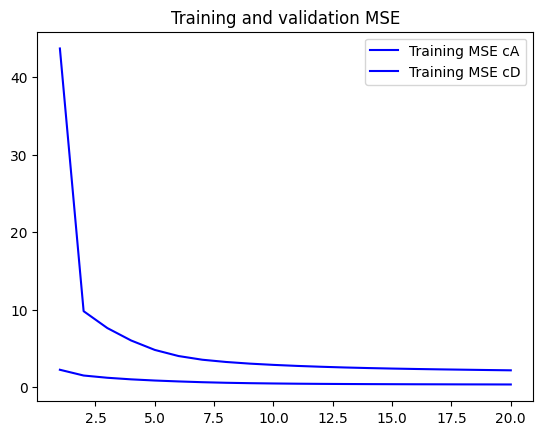

In [20]:
loss_cA = history_cA.history['loss'] 
loss_cD = history_cD.history['loss'] 
#val_loss = history.history['val_loss'] 
epochs = range(1, len(loss_cA) + 1) 
plt.figure()
plt.plot(epochs, loss_cA, 'blue', label='Training MSE cA')
plt.plot(epochs, loss_cD, 'blue', label='Training MSE cD')
#plt.plot(epochs, val_loss, 'green', label='Validation MAE')
plt.title('Training and validation MSE')
plt.legend()
plt.show()

In [21]:
coeffs = model_cA.predict(X_test), model_cD.predict(X_test) 

y_pred = pywt.waverec(coeffs, wavelet, mode)
y_pred[y_pred < 0] = 0

y_true = y_test.reshape(-1, step_ahead) 

error = y_pred - y_true

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(np.square(error).mean())
mae = np.abs(error).mean()
mape = np.abs(error / y_true).mean() * 100

print("Common error metrics:\n\nR2-Score: {}\nRMSE: {}\nMAE : {}\nMAPE : {}"
      .format(r2, rmse, mae, mape))

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
Common error metrics:

R2-Score: 0.8603460268456177
RMSE: 1.850545046371368
MAE : 1.0454115148813596
MAPE : nan


/var/folders/pz/kvbp4_tx4gj8hj2xjrqppmvr0000gn/T/ipykernel_89767/3414637932.py:13: RuntimeWarning: divide by zero encountered in divide
  mape = np.abs(error / y_true).mean() * 100
/var/folders/pz/kvbp4_tx4gj8hj2xjrqppmvr0000gn/T/ipykernel_89767/3414637932.py:13: RuntimeWarning: invalid value encountered in divide
  mape = np.abs(error / y_true).mean() * 100


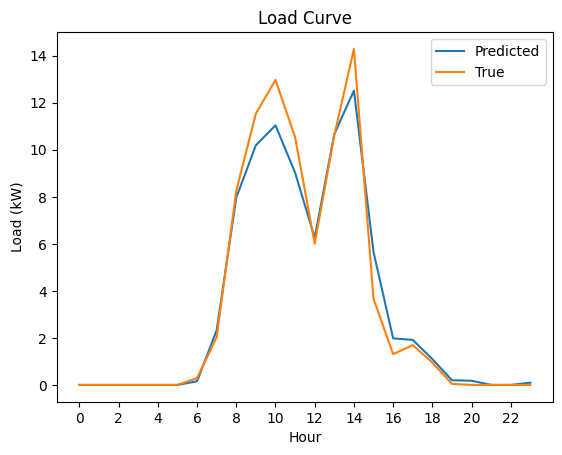

In [22]:
i = 11
plt.plot(y_pred[24*i], label='Predicted')
plt.plot(y_true[24*i], label='True')

plt.title('Load Curve')
plt.xlabel('Hour')
plt.ylabel('Load (kW)')
plt.xticks(np.arange(0,23,2))
plt.legend()

#plt.savefig('load_curve.png', dpi=600)

plt.show()